# 6.1 CNN/DailyMail 데이터셋

In [1]:
#(뉴스 기사, 요약) -> 요약이 본문에서 추출되지 않고 추상적이라는 특징

from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"특성: {dataset['train'].column_names}")

Found cached dataset cnn_dailymail (C:/Users/jiyou/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

특성: ['article', 'highlights', 'id']


In [2]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])})""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 4051)
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


# 6.2 텍스트 요약 파이프라인

In [3]:
#사용할 모델 - 최대 입력 크기가 각각 다르지만 동일한 입력을 사용하고 출력을 비교하기 위해 입력 텍스트를 2,000자로 제한

sample_text = dataset["train"][1]["article"][:2000]
#딕셔너리에 각 모델이 생성한 요약 저장
summaries = {}

In [4]:
#요약에서는 관례적으로 요약 문장을 줄바꿈으로 나눔
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiyou\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

## 6.2.1 요약 기준 모델

In [5]:
#맨 처음 문장 세 개 선택
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

## 6.2.2 GPT-2

In [ ]:
from transformers import pipeline, set_seed

set_seed(42)

pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

## 6.2.3 T5

In [11]:
#입력을 텍스트 투 텍스트 포맷으로 처리하므로 앞에 "summaries"를 붙일 필요가 없음

pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

C:\Users\jiyou\anaconda3\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


## 6.2.4 BART

In [12]:
#인코더 디코더 구조를 사용하는 모델로 손상된 입력을 재구성하도록 훈련 -> BERT와 GPR-2의 사전 훈련 방식 결합
pipe = pipeline("summarization", model = "facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

## 6.2.5 PEGASUS

In [6]:
from transformers import pipeline, set_seed

set_seed(42)

pipe = pipeline("summarization", model =  "google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

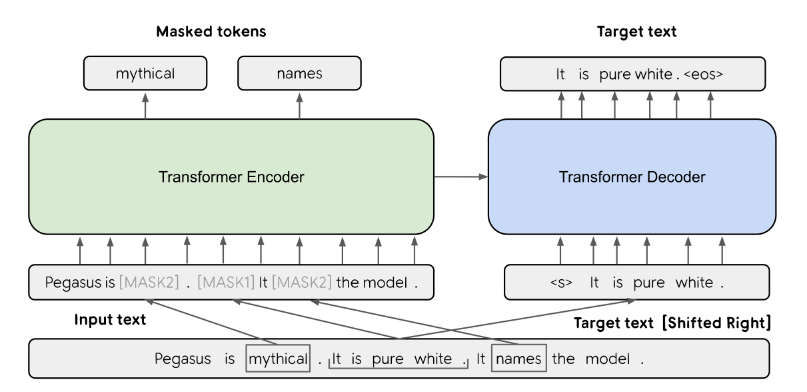

# 6.3 요약 결과 비교하기

GPT-2 :데이터셋에서 훈련된 적 없음
T5 : 여러 작업 중의 하나로 이 작업을 위해 미세 튜닝함
BART & PEGASUS : 이 작업만을 위해 미세 튜닝함

In [7]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

PEGASUS
Mentally ill inmates in Miami are housed on the "forgotten floor"<n>The ninth floor is where they're held until they're ready to appear in court.
Most often, they face drug charges or charges of assaulting an office

GPT-2는 진짜 요약을 생성하도록 명시적으로 훈련되지 않았기에 가끔 사실을 지어낼 때가 있음

# 6.4 생성된 텍스트 품질 평가하기

## 6.4.1 BLEU

- 텍스트 비교시 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자주 등장하는지 카운트 후 생성된 텍스트 길이로 나누는데 동일 단어가 반복되면 정밀도가 완벽해진다는 단점이 존재 -> 이를 막기 위해 단어를 참조 텍스트에 등장한 횟수만큼만 카운트
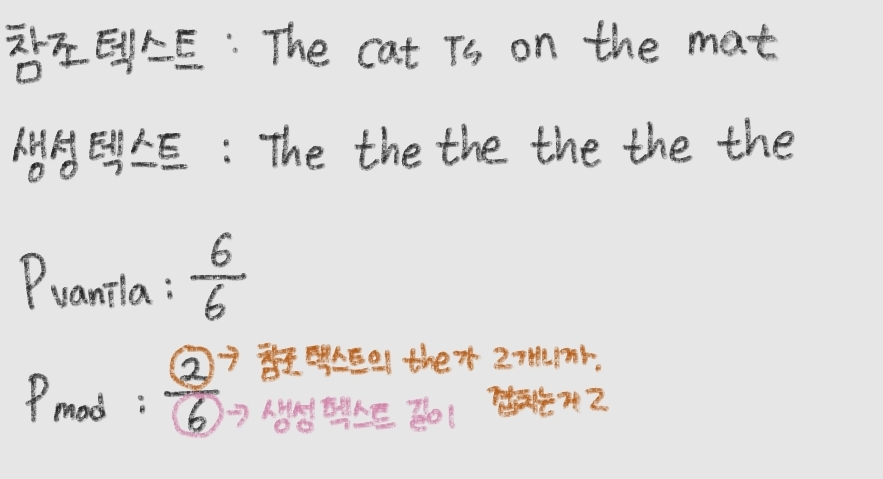
- 생성된 텍스트가 snt와 참조 문장 snt'를 비교, 특정 n에 대해 가능한 모든 n-gram을 추출해 정밀도 계산
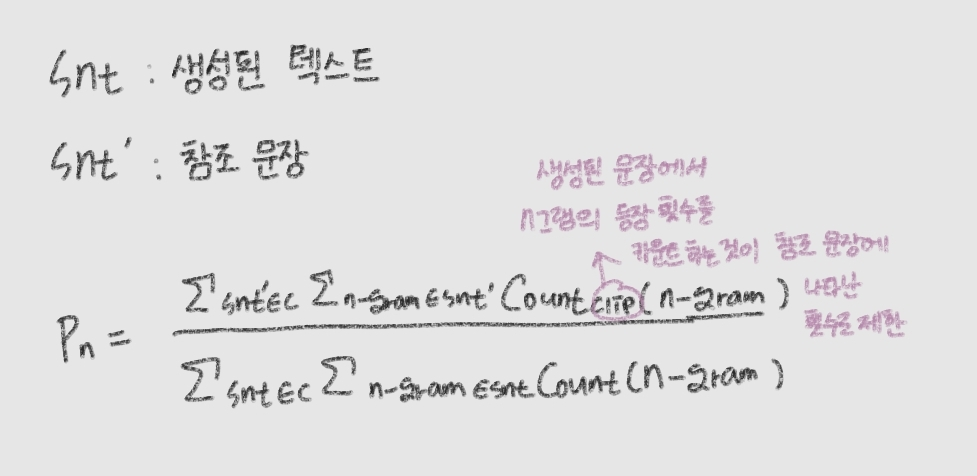
- 재현율을 고려하지 않기에 짧게 생성된 텍스트의 정밀도 점수가 더 높음 -> 브레비티 패널티(Brevity Penalty)
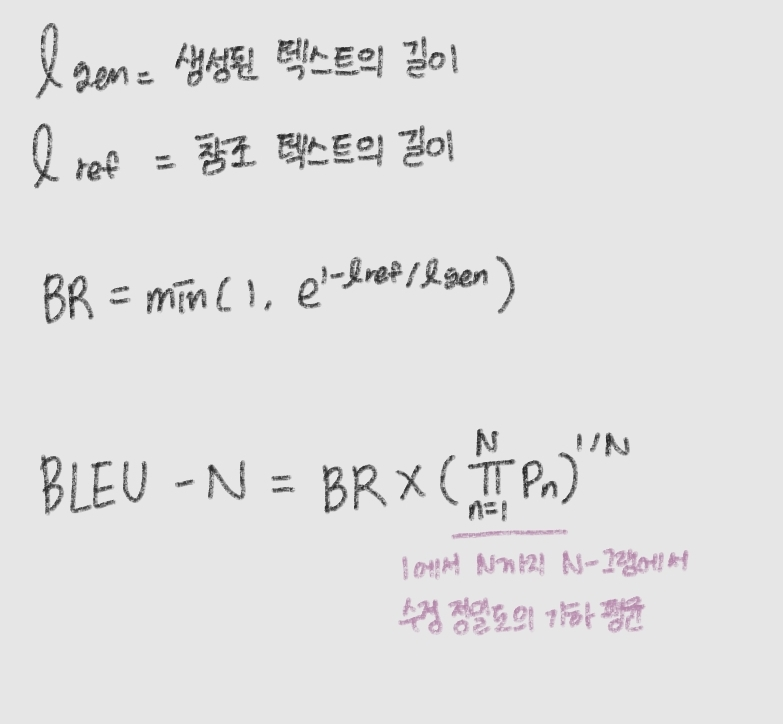

In [8]:
from datasets import load_metric

#BLEU지표는 토큰화된 텍스트를 기대하는데 만약 텍스트 토큰화를 정확히 같은 방법으로 하지 않으면 결과가 달라지는 문제 존재
#이를 해결하기 위해 토큰화 단계를 내재화한 SacreBLUE 사용
bleu_metric = load_metric("sacrebleu")

C:\Users\jiyou\AppData\Local\Temp\ipykernel_19652\100217227.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


smooth_method가 'floor'이면 smooth_value의 기본값이 0.1이고 n그램이 없을 경우 분자로 0.1을 사용

smooth_method가 'add-k'이면 smooth_value의 기본값이 1이고 n그램이 없을 경우 분모와 문자에 1이 더해짐

smooth_method의 기본값은 'exp'이며 smooth_value를 사용하지 않고 n그램이 없을 경우 2의 거듭제곱을 누적해 분모에 곱한 역수를 계산

In [9]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
#1그램의 정밀도는 2, 나머지 2/3/4 그램의 정밀도는 모두 0

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [10]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value =0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


## 6.4.2 ROUGE

- 높은 재현율이 정밀도보다 훨씬 더 중요한 요약 같은 애플리케이션을 위해 특별히 개발
- 참조 텍스트에 있는 n-그램이 생성 텍스트에 얼마나 많이 등장하는지 확인한다는 점에서 다름(BLEU는 반대)
- ROUGE의 원래 공식 -> 정밀도를 완전히 제거하면 부정적인 영향이 커지므로 클리핑 카운트를 하지 않는 BLEU 공식으로 돌아가 정밀도를 측정한 다음 정밀도와 재현율 ROUGE 점수를 조화 평균하면 F-1 점수가 나옴
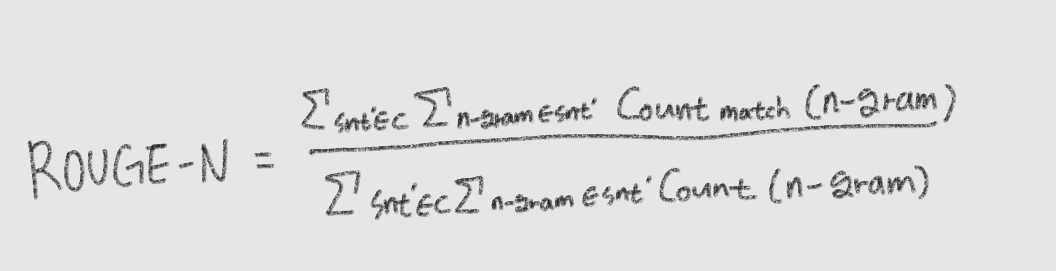
- LCS(longest common subsequence)를 측정하는 ROUGE-L
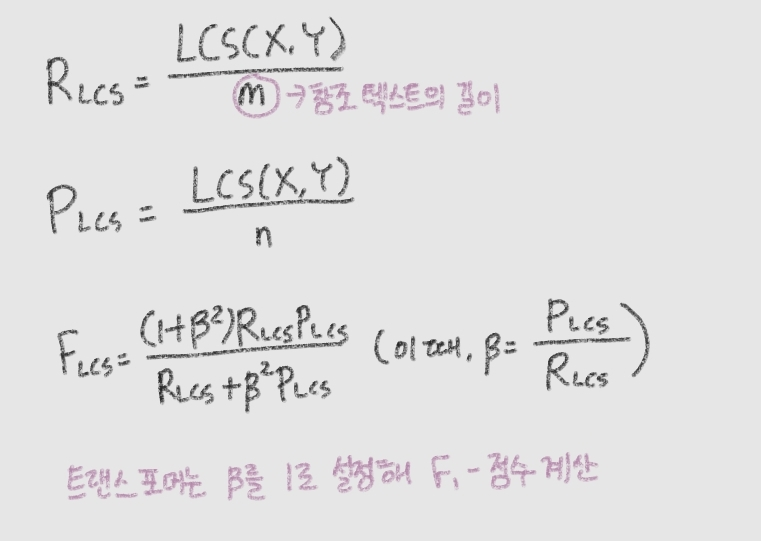

In [11]:
#rouge-L: 문장마다 점수를 계산해서 요약에 대해 평균한 점수
#rouge-Lsum: 전체 요약에 대해 계산한 점수

rouge_metric = load_metric("rouge")

In [12]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index = summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
pegasus,0.323232,0.206186,0.282828,0.323232


# 6.5 CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [13]:
def evaluate_summaries_baseline(dataset, metric,
                               column_text="article",
                               column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                    references=dataset[column_summary])
    score = metric.compute()
    return score

In [14]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [15]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

데이터셋을 동시에 처리하기 위해 작은 배치로 나눈 후 각 배치의 입력 샘플을 토큰화하고 generate() 함수에 전달해 빔 서치로 요약 생성

생성된 텍스트를 디코딩하고 <N>토큰을 공백으로 바꾸고 디코딩된 토큰과 참조 텍스트를 지표에 추가한 후 ROUGE 점수를 계산하고 반환

In [19]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

  1%|▌                                                                        | 1/125 [3:33:42<441:40:32, 12822.84s/it]


KeyboardInterrupt: 

# 6.6 요약 모델 훈련하기

In [ ]:
!pip install py7zr

In [16]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\n요약:")
print(dataset_samsum["test"][0]["summary"])

  0%|          | 0/3 [00:00<?, ?it/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


## 6.6.1 SAMSum에서 PEGASUS 평가하기

In [17]:
from transformers import pipeline, set_seed

pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [18]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                  tokenizer, column_text = "dialogue",
                                  column_summary="summary", batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index)

NameError: name 'model' is not defined

## 6.6.2 PEGASUS 미세 튜닝하기

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokeznier.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                               truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokeznier(example_batch["summary"], max_length=128,
                                    truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
                "attention_mask": input_encodings["attention_mask"],
                "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weigth_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_starategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer = Trainer(model=model, args=training_args,
                 tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                 train_dataset=dataset_samsum_pt["train"],
                 eval_datasets=dataset_samsum_pt["validation"])

In [ ]:
trainer.trainer()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

In [ ]:
trainer.push_to_hub("Training complete")

## 6.6.3 대화 요약 생성하기

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length":128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model = "rjy/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])